# Lecture 8: Symmetric eigenvalue problem and SVD

## Recap of the first part

- QR decomposition and Gram-Schmidt algorithm
- Schur decomposition and QR-algorithm (basic)

## Plan for today

Today we will talk about:

- Algorithms for the symmetric eigenvalue problems
    - QR algorithm (in more details)
    - Divide-and-Conquer
    - bisection
- Algorithms for SVD computation

## Schur form computation

- Recall that we are trying to avoid $\mathcal{O}(n^4)$ complexity. 
- The idea is to make a matrix have a simpler structure so that each step of QR algorithm becomes cheaper.

- In case of a general matrix we can use the **Hessenberg form**.

## Hessenberg form

The matrix $A$ is said to be in the Hessenberg form, if

$$a_{ij} = 0, \quad \mbox{if } i \geq j+2.$$

$$H = \begin{bmatrix} * & * & * & * & * \\ * & * & * & * & * \\ 0 & * & * & * & *\\ 0 & 0 & * & * & *\\ 0 & 0 & 0 & * & * \\ \end{bmatrix}.$$

## Reduction any matrix to Hessenberg form

- By applying Householder reflections we can reduce any matrix to the Hessenberg form

$$U^* A U = H$$

- The only difference with Schur decomposition is that we have to map the first column to the vector with two non-zeros, and the first element is not changed.

- The computational cost of such reduction is $\mathcal{O}(n^3)$ operations.

- In a Hessenberg form, computation of one iteration of the QR algorithm costs $\mathcal{O}(n^2)$ operations (e.g. using Givens rotations, how?), and the Hessenberg form is preserved by the QR iteration (check why).

## Symmetric (Hermitian) case

- In the symmetric case, we have $A = A^*$, then $H = H^*$ and the upper Hessenberg form becomes tridiagonal matrix.

- From now on we will talk about the case of symmetric tridiagonal form.

- Any symmetric (Hermitian) matrix can be reduced to the tridiagonal form by Householder reflections.

- **Key point** is that tridiagonal form is preserved by the QR algorithm, and the cost of one step can be reduced to $\mathcal{O}(n)$!

## QR algorithm: iterations

- The iterations of the QR algorithm have the following form:

$$A_k = Q_k R_k, \quad A_{k+1} = R_k Q_k.$$

- If $A_0 = A$ is <font color='red'> tridiagonal symmetric matrix </font>, this form is preserved by the QR algorithm.

Let us see..

DeviceArray([-1.47168069, -0.75157939,  0.        ,  0.        ,
              0.        ,  0.        ,  0.        ,  0.        ,
              0.        ,  0.        ,  0.        ,  0.        ,
              0.        ,  0.        ,  0.        ,  0.        ,
              0.        ,  0.        ,  0.        ,  0.        ],            dtype=float64)

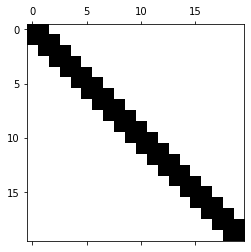

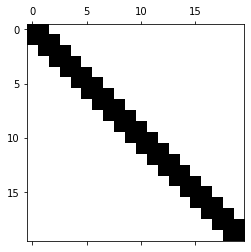

In [1]:
%matplotlib inline
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
#Generate a random tridiagonal matrix

n = 20
d = jax.random.normal(jax.random.PRNGKey(0), (n, ))
sub_diag = jax.random.normal(jax.random.PRNGKey(1), (n-1,))

mat = jnp.diag(d) + jnp.diag(sub_diag, -1) + jnp.diag(sub_diag, 1)
mat1 = jnp.abs(mat)
mat1 = mat1/jnp.max(mat1.flatten())
plt.spy(mat)
q, r = jnp.linalg.qr(mat)
plt.figure()
b = r.dot(q)
# b[abs(b) <= 1e-12] = 0
b = jax.ops.index_update(b, jax.ops.index[abs(b) <= 1e-12], 0)
plt.spy(b)
#plt.figure()
#plt.imshow(np.abs(r.dot(q)))
b[0, :]

## Tridiagonal form

- In the tridiagonal form, you do not have to compute the $Q$ matrix: you only have to compute the **triadiagonal part** that appears after the iterations 

$$A_k = Q_k R_k, \quad A_{k+1}  = R_k Q_k,$$

in the case when $A_k = A^*_k$ and is also tridiagonal.

- Such matrix is defined by $\mathcal{O}(n)$ parameters; computation of the QR is more complicated, but it is possible to compute $A_{k+1}$ directly without computing $Q_k$.

- This is called **implicit QR-step**.

## Theorem on implicit QR iteration

All the implicit QR algorithms are based on the following **theorem**: 

Let 

$$Q^* A Q = H$$ 

be an irreducible upper Hessenberg matrix. Then, the first column of the matrix $Q$ defines all of its other columns. 
It can be found from the equation

$$A Q = Q H. $$


## Convergence of the QR-algorithm

- The convergence of the QR-algorithm is a very **delicate issue** (see E. E. Tyrtyshnikov, "Brief introduction to numerical analysis" for details). 


**Summary.** If we have a decomposition of the form

$$A = X \Lambda X^{-1}, \quad A = \begin{bmatrix}A_{11} & A_{12} \\ A_{21} & A_{22}\end{bmatrix}$$

and 

$$
\Lambda = \begin{bmatrix} \Lambda_1 & 0 \\ 
0 & \Lambda_2 \end{bmatrix}, \quad \lambda(\Lambda_1)=\{\lambda_1,\dots,\lambda_m\}, \ \lambda(\Lambda_2)=\{\lambda_{m+1},\dots,\lambda_r\},
$$

and there is a **gap** between the eigenvalues of $\Lambda_1$ and $\Lambda_2$ ($|\lambda_1|\geq \dots \geq |\lambda_m| > |\lambda_{m+1}| \geq\dots \geq |\lambda_r| >0$), then the $A^{(k)}_{21}$ block of $A_k$
in the QR-iteration goes to zero with 

$$\Vert A^{(k)}_{21} \Vert \leq  C q^k, \quad q = \left| \frac{\lambda_{m+1}}{\lambda_{m}}  \right |,$$

where $m$ is the size of $\Lambda_1$.

So we need to increase the gap!  It can be done by the **QR algorithm with shifts**.

## QR-algorithm with shifts

$$A_{k} - s_k I = Q_k R_k, \quad A_{k+1} = R_k Q_k + s_k I$$


The convergence rate for a shifted version is then

$$\left| \frac{\lambda_{m+1} - s_k}{\lambda_{m} - s_k}  \right |,$$

where $\lambda_m$ is the $m$-th largest eigenvalue of the matrix in modulus. 
- If the shift is close to the eigenvalue, then the convergence speed is better.
- There are different strategies to choose shifts. 
- Introducing shifts is a general strategy to improve convergence of iterative methods of finding eigenvalues. 
- In next slides we will illustrate how to choose shift on a simpler algorithm.

## Shifts and power method

- Remember the power method for the computation of the eigenvalues.

$$x_{k+1} := A x_k, \quad x_{k+1} := \frac{x_{k+1}}{\Vert x_{k+1} \Vert}.$$

- It converges to the eigenvector corresponding to the largest eigenvalue in modulus. 

- The convergence can be very slow.

- Let us try to use shifting strategy. If we shift the matrix as 

$$  A := A - \lambda_k I$$

and the corresponding eigenvalue becomes small (but we need large). 
- That is not what we wanted!

## Inverse iteration and Rayleigh quotient iteration

- To make a small eigenvalue large, we need to **invert the matrix**, and that gives us **inverse iteration**

$$x_{k+1} = (A - \lambda I)^{-1} x_k,$$

where $\lambda$ is the shift which is approximation to the eigenvalue that we want. 

- As it was for the power method, the convergence is linear.

- To accelerate convergence one can use the **Rayleigh quotient iteration** (inverse iteration with adaptive shifts) which is given by the selection of the **adaptive shift**:

$$x_{k+1} = (A - \lambda_k I)^{-1} x_k,$$

$$\lambda_k = \frac{(Ax_k, x_k)}{(x_k, x_k)}$$

- In the symmetric case $A = A^*$ the convergence is **locally cubic** and **locally quadratic** otherwise.

## Singular values and eigenvalues (1)

- Now let us talk about singular values and eigenvalues. 

- SVD 

$$A = U \Sigma V^*$$

exists for any matrix.

- It can be also viewed as a reduction of a given matrix to the diagonal form by means of two-sided unitary transformations:

$$\Sigma = U^* A V.$$

- By two-sided Householder transformation we can reduce any matrix to the **bidiagonal form** $B$ (how?).

## Singular values and eigenvalues (2)

- **Implicit QR algorithm** (with shifts) gives the way of computing the eigenvalues (and Schur form).

- But we cannot apply QR algorithm directly to the bidiagonal matrix, as it is not diagonalizable in general case.

- However, the problem of the computation of the SVD can be reduced to the **symmetric eigenvalue problem** in two ways:


1. Work with the tridiagonal matrix 

$$T = B^* B$$ 

2. Work with the extended matrix 

$$T = \begin{bmatrix} 0 & B \\ B^* & 0 \end{bmatrix}$$

- The case 1 is OK if you **do not form T directly**!

- Thus, the problem of computing singular values can be reduced to the problem of the computation of the eigenvalues of symmetric tridiagonal matrix.

## Algorithms for the SEV  (symmetric eigenvalue problem)

Done:
- QR algorithm: the "gold standard" of the eigenvalue computations
- RQI-iteration: Rayleigh quotient iteration is implicitly performed at each step of the QR algorithm

Next slides:
- Divide-and-conquer
- Bisection method
- Jacobi method

## Divide-and-conquer

- Suppose we have a tridiagonal matrix, and we split it into two blocks:

$$T = \begin{bmatrix} T'_1 & B \\ B^{\top} & T'_2 \end{bmatrix}$$

- We can write the matrix $T$ as

$$T = \begin{bmatrix} T_1 & 0 \\ 0 & T_2 \end{bmatrix} + b_m v v^*$$

where $vv^*$ is rank 1 matrix, $v = (0,\dots,0,1,1,0,\dots,0)^T$.

- Suppose we have decomposed $T_1$ and $T_2$ already:

$$T_1 = Q_1 \Lambda_1 Q^*_1, \quad T_2 = Q_2 \Lambda_2 Q^*_2$$

- Then (check),

$$\begin{bmatrix} Q^*_1 & 0 \\ 0 & Q^*_2 \end{bmatrix} T\begin{bmatrix} Q_1 & 0 \\ 0 & Q_2 \end{bmatrix} = D + \rho u u^{*}, \quad D = \begin{bmatrix} \Lambda_1 & 0 \\ 0 & \Lambda_2\end{bmatrix}$$

- I.e. we have reduced the problem to the problem of the computation of the eigenvalues of <font color='red'> diagonal plus low-rank matrix </font>



## Diagonal-plus-low-rank matrix

It is tricky to compute the eigenvalues of the matrix

$$D + \rho u u^* $$

The characteristic polynomial has the form

$$\det(D + \rho uu^* - \lambda I) = \det(D - \lambda I)\det(I + \rho (D - \lambda I)^{-1} uu^*) = 0.$$

Then (prove!!) 

$$\det(I + \rho (D - \lambda I)^{-1} uu^*) = 1 + \rho \sum_{i=1}^n \frac{|u_i|^2}{d_i - \lambda} = 0$$

Hint: find $\det(I + w u^*)$ using the fact that $\text{det}(C) = \prod_{i=1}^n\lambda_i(C)$ and $\text{trace}(C) = \sum_{i=1}^n \lambda_i$.

## Characteristic equation

$$1 + \rho \sum_{i=1}^n \frac{|u_i|^2}{d_i - \lambda} = 0$$

How to find the roots?

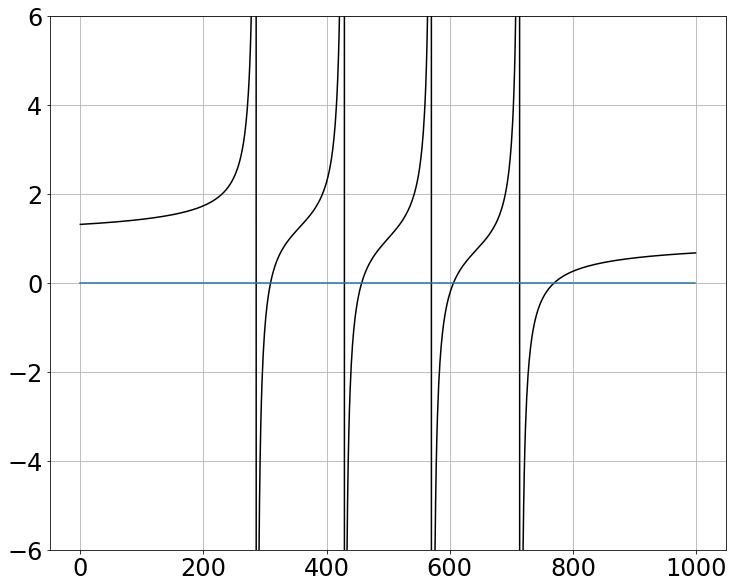

In [2]:
import jax.numpy as jnp

lm = [1, 2, 3, 4]
M = len(lm)
D = jnp.array(lm)
a = jnp.min(lm)
b = jnp.max(lm)
t = jnp.linspace(-1, 6, 1000)
u = 0.5 * jnp.ones(M)
rho = 1
def fun(lam):
    return 1 + rho * jnp.sum(u**2/(D - lam))
res = [fun(lam) for lam in t]
plt.figure(figsize=(10,8))
plt.plot(res, 'k')
plt.plot(jnp.zeros_like(t))
plt.ylim([-6, 6])
plt.tight_layout()
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.grid(True)

- The function has only one root at $[d_i, d_{i+1}]$

- We have proved, by the way, the **Cauchy interlacing theorem** (what happens to the eigenvalues under rank-$1$ perturbation)

## How to find the root

- A Newton method will fail (draw a picture with a tangent line).

- Note that Newton method is just approximation of a function $f(\lambda)$ by a linear function.

- Much better approximation is the **hyperbola**:

$$f(\lambda) \approx c_0 + \frac{c_1}{d_i - \lambda} + \frac{c_2}{d_{i+1} - \lambda}.$$

- To fit the coefficients, we have to evaluate $f(\lambda)$ and $f'(\lambda)$ in the particular point.

- After that, the approximation can be recovered from solving **quadratic equation**




## Important issues

- First, stability: this method was abandoned for a long time due to instability of the computation of the eigenvectors.

- In the recursion, we need to compute the eigenvectors of the $D + \rho uu^*$ matrix.

- The exact expression for the eigenvectors is just (let us check!)

$$(D - \alpha_i I)^{-1}u,$$ where $\alpha_i$ is the computed root.

- The reason of instability:
    - if $\alpha_i$ and $\alpha_{i+1}$ are close, then the corresponding eigenvectors are collinear, but they have to be orthogonal
    - if $\alpha_i$ and $\alpha_{i+1}$ are close, then they close to $d_i$, therefore matrices $D - \alpha_i I$ and $D - \alpha_{i+1} I$ are close to singular

## Loewner theorem

- The solution came is to use a strange **Loewner theorem:**

If $\alpha_i$ and $d_i$ satisfy the **interlacing theorem** 

$$d_n < \alpha_n < \ldots < d_{i+1} < \alpha_{i+1} \ldots$$

Then there exists a vector $\widehat{u}$ such that $\alpha_i$ are exact eigenvalues of the matrix

$$\widehat{D} = D + \widehat{u} \widehat{u}^*.$$

- So, you first compute the eigenvalues, then compute $\widehat{u}$ and only then the eigenvectors.

## Divide and conquer and the Fast Multipole Method

In the computations of divide and conquer we have to evaluate the sums of the form

$$f(\lambda) = 1 + \rho \sum_{i=1}^n \frac{|u_i|^2}{(d_i - \lambda)},$$

and have to do it at least for $n$ points. 

- The complexity is then $\mathcal{O}(n^2)$, as for the QR algorithm.

- Can we make it $\mathcal{O}(n \log n)$? 

- The answer is yes, but we have to replace the computations by the approximate ones
by the help of **Fast Multipole Method**.

Lets explain a little bit...

## Few more algorithms

- Absolutely different approach is based on the **bisection**.

- Given a matrix $A$ its inertia is defined as a triple 

$$(\nu, \zeta, \pi),$$

where $\nu$ is the number of negative, $\zeta$ - zero and $\pi$ - positive eigenvalues. 

- If $X$ is non-singular, then 

$$Inertia(A) = Inertia(X^* A X)$$

## Bisection via Gaussian elimination

- Given $z$ we can do the Gaussian elimination:

$$A - zI = L D L^*,$$

and inertia of the diagonal matrix is trivial to compute.

- Thus, if we want to find all the eigenvalues in the interval $a$, $b$

- Using inertia, we can easily count the number of eigenvalues in an interval. 
- Illustration: if $Inertia(A)=(5,0,2)$ and after shift $Inertia(A-zI)=(4,0,3)$, $z\in[a,b]$ then we know that $\lambda(A)\in[a,z]$.

## Jacobi method

- Recall what a Jacobi (Givens rotations) are

- In a plane they correspong to a $2 \times 2$ orthogonal matrix of the form

$$\begin{pmatrix} \cos \phi & \sin \phi \\ -\sin \phi & \cos \phi \end{pmatrix},$$

and in the $n$-dimensional case we select two variables $i$ and $j$ and rotate.

## Jacobi method (cont.)

- The idea of the Jacobi method is to minimize sum of squares of off-diagonal elements:

$$\Gamma(A) = \mathrm{off}( U^* A U), \quad \mathrm{off}^2(X) = \sum_{i \ne j} \left|X_{ij}\right|^2 = \|X \|^2_F - \sum\limits_{i=1}^n x^2_{ii}.$$

by applying succesive Jacobi rotations $U$ to zero off-diagonal elements. 

- When the "pivot" is chosen, it is easy to eliminate it. 

- The main question is then what is the order of **sweeps** we have to make (i.e. in which order to eliminate).

- If we always eliminate the largest off-diagonal elements the method has quadratic convergence.

- In practice, a cyclic order (i.e., $(1, 2), (1, 3), \ldots, (2, 3), \ldots$) is used.

## Jacobi method: convergence

- To show convergence, we firstly show that 

$$ \text{off}(B) < \text{off}(A), $$

where $B = U^*AU$.

- In this case we use the unitary invariance of Frobenius norm and denote by $p$ and $q$ the indices that is changed after rotation:

$ \Gamma^2(A) = \text{off}^2(B) =  \|B\|^2_F - \sum\limits_{i=1}^n b^2_{ii} = \| A \|^2_F - \sum\limits_{i \neq p, q} b^2_{ii} - (b^2_{pp} + b^2_{qq}) = \| A \|^2_F - \sum\limits_{i \neq p, q} a^2_{ii} - (a^2_{pp} + 2a^2_{pq} + a^2_{qq}) = \| A \|^2_F - \sum\limits_{i =1}^n a^2_{ii} - 2a^2_{pq} = \text{off}^2(A) - 2a^2_{pq} < \text{off}^2(A)$

- We show that the ''size'' of off-diagonal elements decreases after Jacobi rotation.

- If we always select the largest off-diagonal element $a_{pq} = \gamma$ to eliminate (pivot), then we have

$$ |a_{ij}| \leq \gamma, $$

thus  

$$ \text{off}(A)^2 \leq 2 N \gamma^2, $$

where $2N = n(n-1)$ is the number of off-diagonal elements.

- Or rewrite this inequality in the form

$$2\gamma^2 \geq \frac{\text{off}^2(A)}{N}.$$

Now we use relations $\Gamma^2(A) = \text{off}^2(A) - 2\gamma^2 \leq \text{off}^2(A) - \dfrac{\text{off}^2(A)}{N}$ and get

$$ \Gamma(A) \leq \sqrt{\left(1 - \frac{1}{N}\right)} \text{off}(A). $$

- Aften $N$ steps we have the factor

$$\left(1 - \frac{1}{N}\right)^{\frac{N}{2}} \approx e^{-\frac{1}{2}},$$

i.e. linear convergence. However, the convergence is locally quadratic (given without proof here).

## Jacobi: summary

Jacobi method was the first numerical method for the eigenvalues, proposed in 1846.

- Large constant
- Very accurate (high relative error for small eigenvalues)
- Good parallel capabilities

## Summary for this part
- Many algorithms for the computation of the SEV solution:
    - QR
    - Divide-and-conquer
    - Bisection
    - Jacobi

## Next lecture
- We start **sparse and/or structured** NLA.

# Questions?

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()